CS441 Final Project Random Forest Part

Load the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

datadir = "/content/drive/My Drive/CS441/Final Project/"
csv_path = datadir + "T_ONTIME_REPORTING.csv"

Mounted at /content/drive


In [2]:
import pandas as pd
import os

def load_flight_data(path):
  if not os.path.isfile(path):
    raise FileNotFoundError(f"CSV not found at: {path}")
  df = pd.read_csv(path, low_memory=False)
  print(f"Loaded {len(df):,} rows")
  return df

df = load_flight_data(csv_path)
df.head()

# check if file is loaded
print(df.shape)
df.head()


Loaded 539,747 rows
(539747, 24)


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER,ORIGIN,ORIGIN_CITY_NAME,...,DEP_DEL15,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,AA,ABQ,"Albuquerque, NM",...,0.0,733.0,-21.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,AA,ABQ,"Albuquerque, NM",...,0.0,832.0,-17.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,AA,ABQ,"Albuquerque, NM",...,0.0,1052.0,-22.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,AA,ABQ,"Albuquerque, NM",...,0.0,1300.0,-23.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,AA,ABQ,"Albuquerque, NM",...,0.0,2005.0,17.0,0.0,NaN,7.0,0.0,10.0,0.0,0.0


In [6]:
# Keep cancelled flights, drop invalid non-cancelled flights
df_cancelled = df[df['CANCELLED'] == 1]
df_not_cancelled = df[(df['CANCELLED'] == 0) & (~df['ARR_DELAY'].isna())]
df = pd.concat([df_cancelled, df_not_cancelled], ignore_index=True)

HUB_AIRPORTS = ['ORD', 'MDW', 'MSP', 'DTW', 'MKE']
df = df[(df['ORIGIN'].isin(HUB_AIRPORTS)) | (df['DEST'].isin(HUB_AIRPORTS))]

# 0 = On-Time, 1 = Delayed, 2 = Cancelled
df['FlightStatus'] = 0
df.loc[df['ARR_DELAY'] > 15, 'FlightStatus'] = 1
df.loc[df['CANCELLED'] == 1, 'FlightStatus'] = 2

features = df[['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME']].copy()

# Convert DEP_TIME to hour, for Cancelled flights encode as -1
features['DEP_HOUR'] = (features['DEP_TIME'] // 100).fillna(-1).astype(int)
features = features.drop(columns=['DEP_TIME'])

# Sanity check
features.head()


,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_HOUR
0,AA,ORD,CLT,-1
1,AS,ORD,PDX,6
2,UA,EGE,ORD,-1
3,UA,RSW,ORD,-1
4,MQ,IND,ORD,-1


Split into training data and validation data

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y   # this is to ensure all classes appear in both sets
)

# print some info in case needed
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nTrain class distribution:")
print(y_train.value_counts())

print("\nTest class distribution:")
print(y_test.value_counts())


Train shape: (71328, 4)
Test shape: (17833, 4)

Train class distribution:
FlightStatus
0    56774
1    13297
2     1257
Name: count, dtype: int64

Test class distribution:
FlightStatus
0    14194
1     3324
2      315
Name: count, dtype: int64


Convert strings into numeric value, so it works with random forest

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']

# Preprocessing: one-hot encoder used on categorical variables, keep numeric features
preprocess = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)


Train the model

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('preprocess', preprocess),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        n_jobs=-1,
        random_state=42
    ))
])

# Train the model
model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['OP_UNIQUE_CARRIER',
                                                   'ORIGIN', 'DEST'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

Validation and evaluate how good the model is

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

val_accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", val_accuracy)

print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=['On-Time', 'Delayed', 'Cancelled']
))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Validation Accuracy: 0.8474737845567207

Classification Report:
              precision    recall  f1-score   support

     On-Time       0.86      0.97      0.91     14194
     Delayed       0.69      0.33      0.45      3324
   Cancelled       1.00      0.97      0.98       315

    accuracy                           0.85     17833
   macro avg       0.85      0.76      0.78     17833
weighted avg       0.83      0.85      0.83     17833


Confusion Matrix:
[[13698   496     0]
 [ 2214  1110     0]
 [    8     2   305]]


Graphical results, might be useful for the report

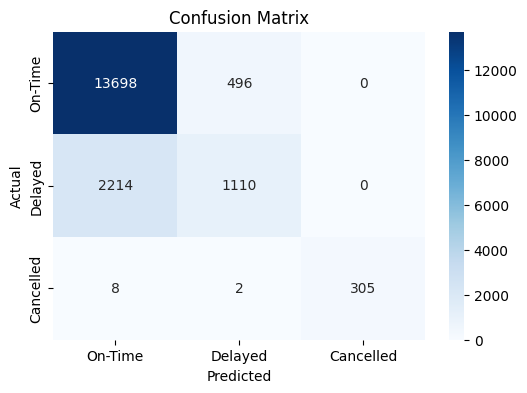

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['On-Time', 'Delayed', 'Cancelled']

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
